### Todo
* L2 loss
* RMSProp
* Adam
* Check if grads are locked before update
* derivs in constructor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.datasets
import utils
import time

import nn_framework.framework as nn

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
def dense(X, input_dim, output_dim):
  W = nn.variable(np.random.randn(output_dim, input_dim))
  b = nn.variable(np.zeros([output_dim, 1]))
  return W @ X + b

X.shape = (2, 1000), Y.shape = (1, 1000)


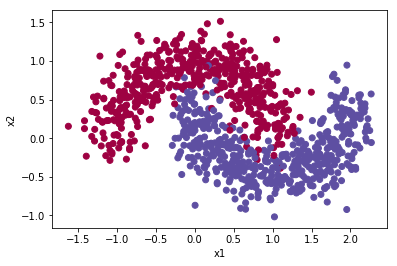

In [3]:
m = 1000
X, Y = sklearn.datasets.make_moons(n_samples=m, noise=0.2)
# X, Y = sklearn.datasets.make_gaussian_quantiles(n_samples=m, n_classes=2)
X = X.T
Y = Y.reshape(-1, 1).T

print('X.shape = %s, Y.shape = %s' % (X.shape, Y.shape))
plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral)
plt.ylabel('x2')
plt.xlabel('x1')

In [4]:
def compare(a, b):
  return np.linalg.norm(a - b) / (np.linalg.norm(a) + np.linalg.norm(b))

tf.reset_default_graph()
m = 1000
n = 20
n_h = 50

w = np.random.randn(n_h, n)
b = np.random.randn(n_h, 1)
t1 = np.random.randn(n, n_h)
t2 = np.random.randn(n, m)

# TensorFlow
wtf = tf.constant(w)
biastf = tf.constant(b)
atf = wtf * 2
atf *= atf
btf = (tf.matmul(t1, tf.matmul(wtf, t2)) + 1) * 2 - 3
btf *= btf

ztf = tf.matmul(atf, btf) + biastf ** 2
ztf *= ztf
[dwtf, dbtf] = tf.gradients(ztf, [wtf, biastf])

# My :D
wmy = nn.variable(w)
biasmy = nn.variable(b)
amy = wmy * 2
amy *= amy
bmy = (nn.const(t1) @ wmy @ t2 + 1) * 2 - 3
bmy *= bmy

zmy = amy @ bmy + biasmy ** 2
zmy *= zmy
dwmy, dbmy = zmy.deriv(wmy, nn.ones(zmy.shape)), zmy.deriv(biasmy, nn.ones(zmy.shape))

with tf.Session() as sess:
  [dwtf_val, dbtf_val] = sess.run([dwtf, dbtf])
  [dwmy_val, dbmy_val] = nn.Session().run([dwmy, dbmy], {})
  
  assert dwtf_val.shape == dwmy_val.shape, 'dw shapes should match'
  assert dbtf_val.shape == dbmy_val.shape, 'db shapes should match'
  
  dw_mse = compare(dwtf_val, dwmy_val)
  db_mse = compare(dbtf_val, dbmy_val)
  
  print('actual test: dw mse: %s, db mse: %s' % (dw_mse, db_mse))

actual test: dw mse: 2.56325907074e-16, db mse: 2.07794099678e-16


gradient check: 7.01784284243e-08
step: 0, loss: 0.457533, accuracy: 74.9
step: 200, loss: 0.244717, accuracy: 89.6
step: 400, loss: 0.217920, accuracy: 91.3
step: 600, loss: 0.195986, accuracy: 92.7
step: 800, loss: 0.176391, accuracy: 93.9
2.194835901260376


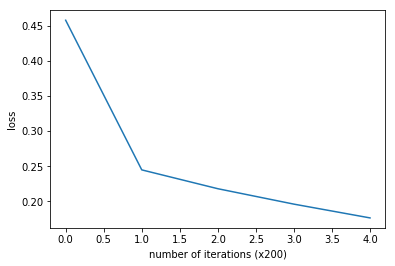

In [5]:
# var = nn.variable(np.random.randn(2, 3))
# tmp = nn.mean(var)
# dvar = tmp.deriv(var, nn.ones(tmp.shape))
# sess = nn.Session()
# print(sess.run([var]))
# print(sess.run([tmp]))
# print(sess.run([dvar]))

learning_rate = 0.1
steps = 1000
log_interval = 200
kp = 0.9

assert X.shape[0] == 2

keep_prob = nn.placeholder('keep_prob', [])
A0 = nn.placeholder('X', [X.shape[0], None])
net = A0
net = dense(net, input_dim=2, output_dim=16)
net = nn.relu(net)
# net = nn.dropout(net, keep_prob=keep_prob)
net = dense(net, input_dim=16, output_dim=1)  
net = nn.sigmoid(net)
Y_hat = net

loss = nn.mean(nn.logistic_loss(a=Y_hat, y=Y))
print('gradient check: %s' % nn.gradient_check(loss, {A0: X, keep_prob: 1}))
global_step = nn.variable(0)

# train = nn.GradientDescentOptimizer(loss, learning_rate, global_step)
train = nn.MomentumOptimizer(loss, learning_rate, global_step)
losses = []

sess = nn.Session()

t = time.time()
for i in range(0, steps):
  _, l, Y_hat_val = sess.run([train, loss, Y_hat], {A0: X, keep_prob: kp})
  
  if i % log_interval == 0:
    acc = np.mean(Y == (Y_hat_val > 0.5)) * 100
    print('step: %d, loss: %f, accuracy: %s' % (i, l, acc))
    losses.append(l)
print(time.time() - t)
    
plt.plot(losses)
plt.xlabel('number of iterations (x%s)' % log_interval)
plt.ylabel('loss')

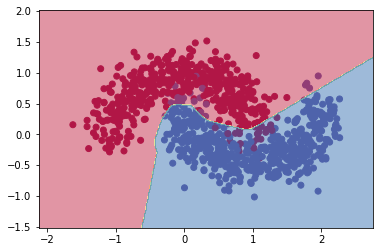

In [6]:
utils.plot_decision_boundary(lambda x: sess.run([Y_hat], {A0: x.T, keep_prob: 1.0})[0] > 0.5, X, Y, cmap=plt.cm.Spectral)